In [9]:
import math
import random
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
from matplotlib import pyplot as plt

Neurons are basically computational units that take inputs and channel them to outputs using hidden layer.
Hidden layer will use a sigmoid function as an **activation function**.

With one hidden layer, vectorized implementation of neural networks might look like this:
$$
\quad
\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3
\end{bmatrix} \rightarrow
\begin{bmatrix}
a_1^{2} \\
a_2^{2} \\
a_3^{2}
\end{bmatrix} \rightarrow
h(x)
$$

Each *a* represent an activation unit.
$$
a_i^{(j)} \text{- "activation" of unit i in layer j}
\\
\Theta^{(j)} \text{- matrix of "weights"}
$$

Each activation node *a* can be calculated in the following way:
\begin{align*} a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \newline a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \newline a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \newline h_\Theta(x) = a_1^{(3)} = g(\Theta_{10}^{(2)}a_0^{(2)} + \Theta_{11}^{(2)}a_1^{(2)} + \Theta_{12}^{(2)}a_2^{(2)} + \Theta_{13}^{(2)}a_3^{(2)}) \newline \end{align*}

## Activation function

Activation function is just a sigmoid function and can be easily calculated using Python:

In [10]:
def sigmoid(z):
    return 1 / (1 + math.e ** (-z))

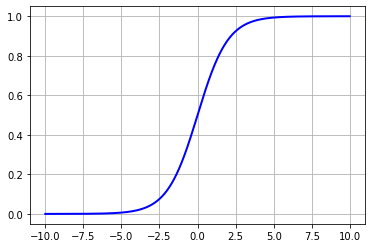

In [11]:
def plot_sigmoid():
    rand_dataset = np.arange(-10., 10., 0.01)
    calculated_dataset = [sigmoid(x) for x in rand_dataset]
    plt.plot(rand_dataset, calculated_dataset, color='b', lw=2)
    plt.gca().grid()

plot_sigmoid()

## Reading data

Andrew's course provides a *.mat file that contains the X and Y values.

X is a matrix of size 5000 x 400 - in other words it contains 5000 'images' of 400 pixels each - i.e. size of each picture is 20 x 20 pixels.

Y is a vector of size 5000 - it contains a single value that represent the actual number displayed in the image. 1 for '1'. 2 for '2' etc. it is just a 0 that is saved in the vector as '10'.

In [12]:
def load_mat(filename):
    mat_data = sio.loadmat(filename)
    return mat_data['X'], mat_data['y']

X, Y = load_mat('./ex3data1.mat')

## Visualizing data

To better understand how the images look like, let's visualize them by selecting random 25 images.

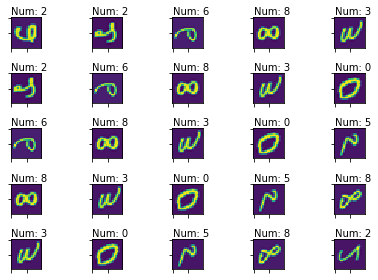

In [13]:
def get_random_img_with_label(x_matrix, y_vector):
    size = np.size(x_matrix, 0)
    rand_img_loc = random.randint(0, size)
    return x_matrix[rand_img_loc].reshape(20, 20), y_vector[rand_img_loc, 0]

def plot_images(images):
    f, axarr = plt.subplots(5, 5)
    for i in range(0, 5):
        for j in range(0, 5):
            img, label = images[i + j]
            axarr[i, j].set_xticklabels([])
            axarr[i, j].set_yticklabels([])
            axarr[i, j].imshow(img)
            axarr[i, j].text(0, -2, f"Num: {0 if label == 10 else label}")
    f.tight_layout()

images = [get_random_img_with_label(X, Y) for x in range(0, 25)]
plot_images(images)

## Cost function

Cost function is exactly the same for neural networs as in logistic regression.

\begin{align}
J(\theta)=\dfrac{1}{m}\sum\limits_{i=1}^{m}[-y^{(i)}log(h_{\theta}(x^{(i)}))-(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]+\dfrac{\lambda}{2m}\sum\limits_{j=1}^{n}\theta_{j}^{2}
\end{align}

\begin{align}
\theta = \dfrac{1}{m}X^{T}(g(X\theta) - y)
\end{align}

In [14]:
def lr_cost_function(theta_matrix, x_matrix, y_vector, lambda_parameter):
    h0x = sigmoid(x_matrix @ theta_matrix)
    m = np.size(y_vector, 0)
    cost = (1 / m) * np.sum(-y_vector * np.log(h0x) - (1 - y_vector) * np.log(1 - h0x), 0) + (lambda_parameter / (2 * m)) * np.sum(theta_matrix[1:] ** 2)
    grad = (1 / m) * x_matrix.transpose() @ (h0x - y_vector) + ((lambda_parameter / m) * theta_matrix)
    grad[0] = ((1 / m) * x_matrix.transpose() @ (h0x - y_vector))[0]
    return cost, grad

## One vs All

Next step is to get all images (X matrix), the result (what the image represent - Y vector) and calculate the minimum cost for each Y.
In other words - the method will calculate what is the most probable representation of the image (a number from 0 to 9).

In [15]:
def one_vs_all(x_matrix, y_vector, num_labels, lambda_parameter):
    m = np.size(x_matrix, 0)
    n = np.size(x_matrix, 1)
    init_theta = np.zeros(((n + 1), 1))
    all_theta = np.zeros((num_labels, n + 1))
    x_matrix = np.column_stack((np.ones((m, 1)), x_matrix))
    for i in range(0, num_labels):
        all_theta[i] = opt.fmin_tnc(func=lr_cost_function,
                                    x0=init_theta.flatten(),
                                    args=(x_matrix, np.where(y_vector == (10 if i == 0 else i), 1, 0).flatten(),
                                          lambda_parameter))[0]
    return all_theta

all_theta = one_vs_all(X, Y, 10, .1)

## Prediction

We have our calculated values using one vs all approach, so now we can use it to predict what is written in the images.
We simply take the index of the highest value - that index is the actual prediction (number represented by an image).

In [16]:
def predict_one_vs_all(all_theta, x_matrix):
    m = np.size(x_matrix, 0)
    x_matrix = np.column_stack((np.ones((m, 1)), x_matrix))
    predict = sigmoid(x_matrix @ all_theta.transpose())
    return np.argmax(predict, 1)

predicted = predict_one_vs_all(all_theta, X)

## Accuracy

Not all predicted values match the actual input value from the initial *.mat file - let's see what is the accuracy of our ML algorithm by calculating the mean.

In [20]:
def pred(predicted_vector, y_vector):
    return np.mean(np.vectorize(lambda y: 1 if y else 0)(predicted_vector.reshape(5000, 1) == y_vector))

print(f"The accuracy is: {pred(predicted, Y) * 100}%")

The accuracy is: 86.48%
